In [33]:
import matplotlib.pyplot as plt
import os
import numpy as np
from neuron import h, load_mechanisms
from netpyne import specs, sim, cell, support

In [34]:
h.load_file("stdrun.hoc")

cwd = os.getcwd()
mod_dir = os.path.join(cwd, 'mod')
load_mechanisms(mod_dir)

Mechanisms already loaded from path: /Users/katedoxey/Desktop/research/projects/tinnitus model/code/tinnitus_model/mod.  Aborting.


True

### Simulation configuration

In [35]:
sim_dur = 500

In [36]:
cfg = specs.SimConfig()					                    # object of class SimConfig to store simulation configuration
cfg.duration = sim_dur 						                # Duration of the simulation, in ms
cfg.dt = 0.025								                # Internal integration timestep to use
cfg.verbose = True							                # Show detailed messages
cfg.recordTraces = {'V_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'v'}}
cfg.recordStep = 0.1
# cfg.recordStim = True
cfg.filename = os.path.join(cwd, 'output', 'tinnitus_small-net') 	# Set file output name
cfg.savePickle = True
cfg.analysis['plotTraces'] = {'include': ['all'], 'saveFig': True}  # Plot recorded traces for this list of cells
cfg.hParams['celsius'] = 34.0 
cfg.hParams['v_init'] = -60

In [37]:
netParams = specs.NetParams()

### Cell parameters

RS - Layer 5 regular spiking pyramidal cell (fig 8.12 from 2007
    	book) Parameters: C=1; k=0.7; vr=-60; vt=-40; vpeak=35;
    	a=0.03; b=-2; c=-50; d=100; celltype=1 Book fig: T = 520 ms;
    	IinRange = [60,70,85,100] pA

In [38]:
IzhCell = {'secs': {}}
IzhCell['secs']['soma'] = {'geom': {}, 'pointps': {}}                        # soma params dict
IzhCell['secs']['soma']['geom'] = {'diam': 10.0, 'L': 10.0, 'cm': 31.831}    # soma geometry
IzhCell['secs']['soma']['pointps']['Izhi'] = {                               # soma Izhikevich properties
    'mod':'Izhi2007b',
    'C':1,
    'k': 0.7,
    'vr':-60,
    'vt':-40,
    'vpeak':35,
    'a':0.03,
    'b':-2,
    'c':-50,
    'd':100,
    'celltype':1}
IzhCell['secs']['soma']['threshold'] = 0
netParams.cellParams['IzhCell'] = IzhCell                                   # add dict to list of cell parameters


### Cell populations

In [39]:
# netParams.popParams['input'] = {'cellModel': 'VecStim',
#                                 'numCells': 1,
#                                 'spikePattern': {'type': 'poisson',
#                                                  'start': 0,
#                                                  'stop': 1000,
#                                                  'frequency': 200}}

pop_labels = ['SGN', 'Int', 'IC', 'Fusi1', 'Fusi2']

for pop_label in pop_labels:
    netParams.popParams[f'{pop_label}_pop'] = {'cellType': 'IzhCell',
                                               'numCells': 1}
    


In [40]:
netParams.stimSourceParams['bkg'] = {'type': 'NetStim', 'rate': 100, 'noise': 0.5}
netParams.stimTargetParams['bkg->ALL'] = {'source': 'bkg', 'conds': {'cellType': ['IzhCell']}, 'weight': 0.01, 'delay': 0, 'synMech': 'exc'}

# netParams.stimSourceParams['bkg'] =  {'type': 'IClamp', 'del': 0, 'dur': sim_dur, 'amp': 'uniform(0.05, 0.5)'}
# netParams.stimTargetParams['bkg->ALL'] = {'source': 'IClamp0', 'sec': 'soma', 'loc': 0.5, 'conds': {'cellType': ['IzhCell']}}

In [41]:
netParams.stimSourceParams['IClamp0'] = {'type': 'IClamp', 'del': 0, 'dur': sim_dur, 'amp': -0.1}
netParams.stimTargetParams['IClamp->SGN'] = {'source': 'IClamp0', 'sec': 'soma', 'loc': 0.5, 'conds': {'pop': 'SGN_pop'}}

In [42]:
# netParams.stimSourceParams['IClamp0'] = {'type': 'IClamp', 'del': 0, 'dur': sim_dur, 'amp': -0.1}
# netParams.stimTargetParams['IClamp->SGN'] = {'source': 'IClamp0', 'sec': 'soma', 'loc': 0.5, 'conds': {'cellList': [0]}}

### Synapses

In [43]:
netParams.synMechParams['exc'] = {'mod': 'ExpSyn', 'tau': 3, 'e': -10}
netParams.synMechParams['inh'] = {'mod': 'ExpSyn', 'tau': 10, 'e': -70}

### Connections

In [44]:
netParams.connParams[f'input->SGN'] = {
    'preConds': {'pop': 'input'},
    'postConds': {'pop': 'SGN_pop'},
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': 1
}

netParams.connParams[f'SGN->Fusi1'] = {
    'preConds': {'pop': 'SGN_pop'},
    'postConds': {'pop': 'Fusi1_pop'},
    'probability': 1,
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': 1
}

netParams.connParams[f'SGN->Fusi2'] = {
    'preConds': {'pop': 'SGN_pop'},
    'postConds': {'pop': 'Fusi2_pop'},
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': 1
}

netParams.connParams[f'Fusi1->IC'] = {
    'preConds': {'pop': 'Fusi1_pop'},
    'postConds': {'pop': 'IC_pop'},
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': 1
}

netParams.connParams[f'IC->Fusi1'] = {
    'preConds': {'pop': 'IC_pop'},
    'postConds': {'pop': 'Fusi1_pop'},
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': 1
}

netParams.connParams[f'Fusi2->IC'] = {
    'preConds': {'pop': 'Fusi2_pop'},
    'postConds': {'pop': 'IC_pop'},
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': 1
}

netParams.connParams[f'IC->Fusi2'] = {
    'preConds': {'pop': 'IC_pop'},
    'postConds': {'pop': 'Fusi2_pop'},
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': 1
}

netParams.connParams[f'IC->Int'] = {
    'preConds': {'pop': 'IC_pop'},
    'postConds': {'pop': 'Int_pop'},
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': 1
}

netParams.connParams[f'Int->Fusi2'] = {
    'preConds': {'pop': 'Int_pop'},
    'postConds': {'pop': 'Fusi2_pop'},
    'synsPerConn': 1,
    'synMech': 'inh',
    'weight': 1
}
netParams.connParams[f'Int->Fusi1'] = {
    'preConds': {'pop': 'Int_pop'},
    'postConds': {'pop': 'Fusi1_pop'},
    'synsPerConn': 1,
    'synMech': 'inh',
    'weight': 1
}


### Simulate


Start time:  2024-09-17 13:48:31.906493

Creating network of 5 cell populations on 1 hosts...
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=0) of pop SGN_pop, on node 0, 
Instantiated 1 cells of population SGN_pop
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=1) of pop Int_pop, on node 0, 
Instantiated 1 cells of population Int_pop
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=2) of pop IC_pop, on node 0, 
Instantiated 1 cells of population IC_pop
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=3) of pop Fusi1_pop, on node 0, 
Instantiated 1 cells of population Fusi1_pop
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=4) of pop Fusi2_pop, on node 0, 
Instantiated 1 cells of population Fusi2_pop
  Number of cells on node 0: 5 
  Done; cell creation time = 0.00 s.
Making connections...
Generating set of probabilistic connections (rul

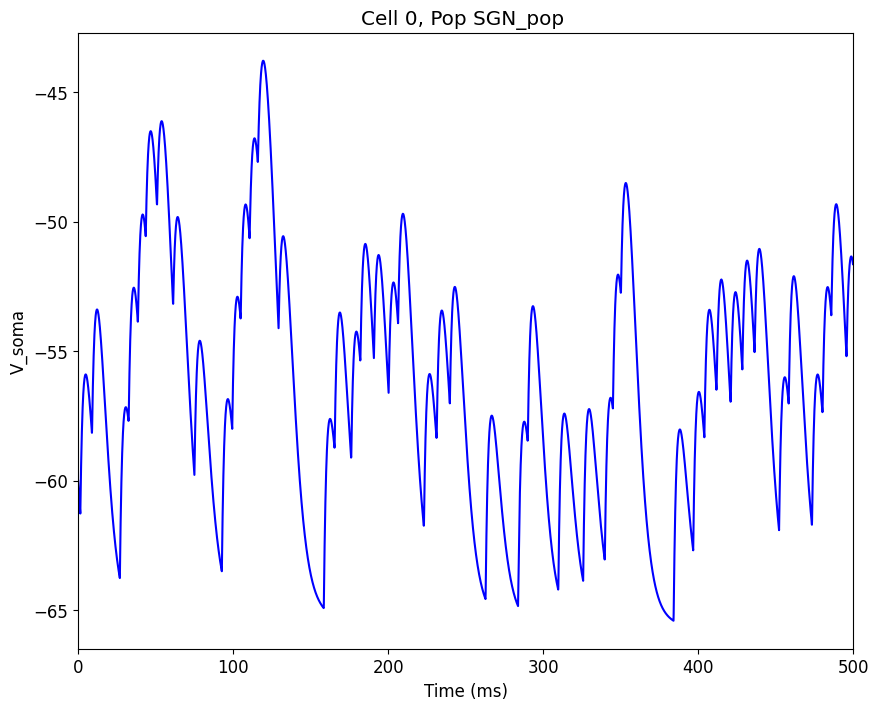

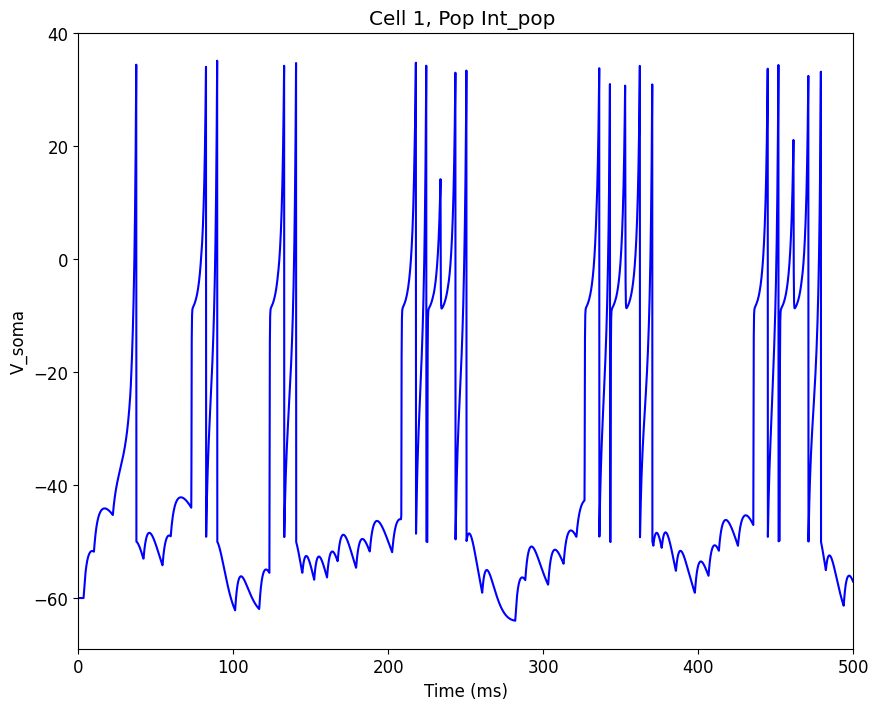

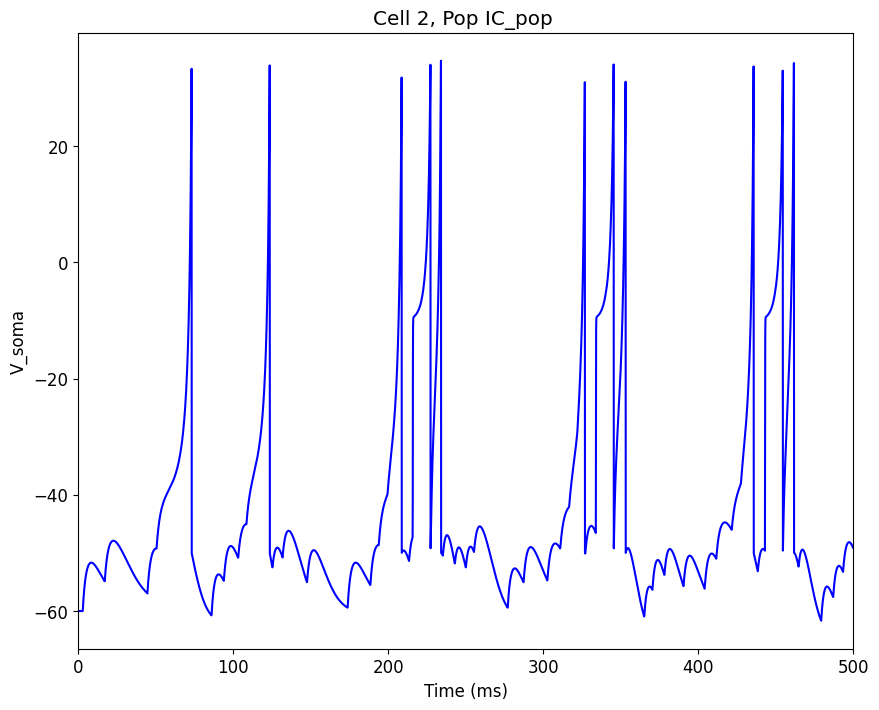

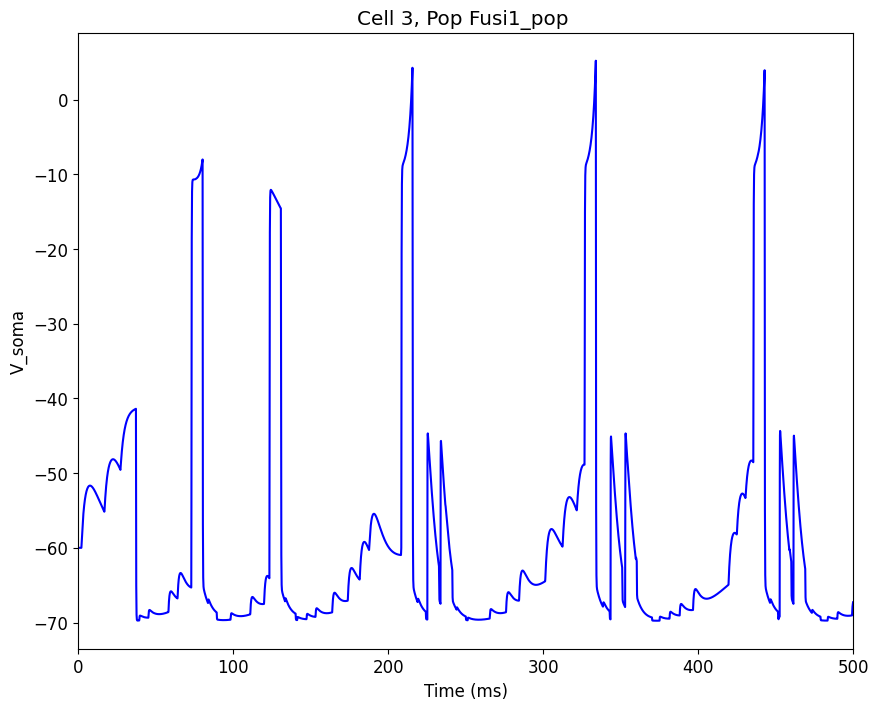

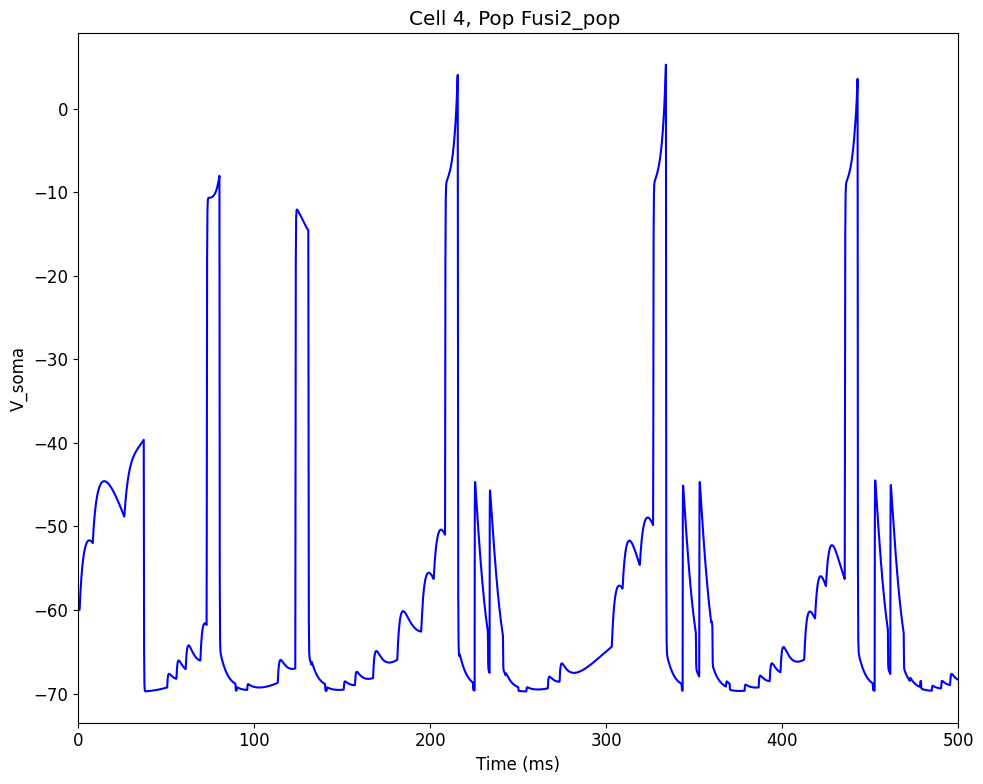

  Done; plotting time = 0.79 s

Total time = 0.85 s


In [45]:
%matplotlib inline
(pops, cells, conns, stims, simData) = sim.createSimulateAnalyze(netParams=netParams, simConfig=cfg, output=True)

In [46]:
temp = 5

SGN_pop: 0 spikes
Int_pop: 20 spikes
IC_pop: 11 spikes
Fusi1_pop: 3 spikes
Fusi2_pop: 3 spikes


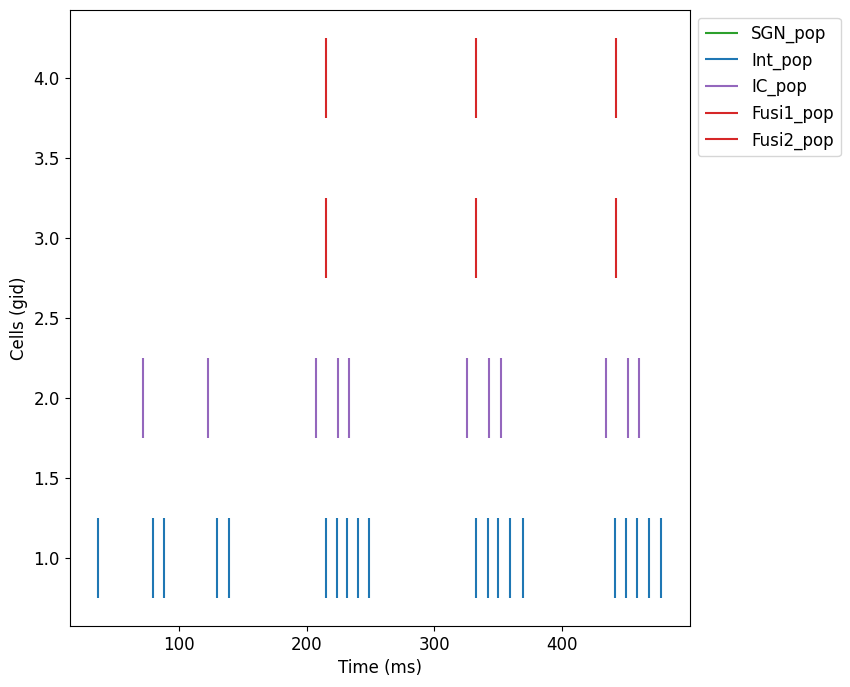

In [47]:
times = np.array(simData['spkt'])
spikes = np.array(simData['spkid'])

colors = {'SGN_pop': 'tab:green', 'Int_pop': 'tab:blue', 'IC_pop': 'tab:purple', 'Fusi1_pop': 'tab:red', 'Fusi2_pop': 'tab:red', 'input': 'tab:cyan'}

fig, axs = plt.subplots(1, 1, figsize=(8,8))

input_spike_t = []

for pop_label, pop in pops.items():
    for gid in pop.cellGids:
        cell = cells[gid]
        spike_times = times[np.where(spikes == gid)]
        if gid == 0:
            input_spike_t = spike_times

        # loc = -1 if gid == 5 else gid
        axs.vlines(spike_times, gid-0.25, gid+0.25, color=colors[pop_label], label=pop_label)

        print(f'{pop_label}: {spike_times.shape[0]} spikes')


axs.legend(loc='upper left', bbox_to_anchor=(1, 1))
# axs.set_yticks([-1, 0, 1, 2, 3, 4])
# axs.set_yticklabels(['5','0','1','2','3', '4'])
axs.set_ylabel('Cells (gid)')
axs.set_xlabel('Time (ms)');

In [48]:
save_inputs = False

if save_inputs:

    in_amp = 3

    t_int = np.arange(0,250,0.1)
    input_spike_ts = [round(input_spike, 1) for input_spike in input_spike_t]
    for input_spike in input_spike_ts:
        t_int[int(input_spike*10)] = in_amp
    t_int[np.where(t_int != in_amp)] = 0
    t_int[int(in_amp*10)] = 0
    np.savetxt(f'inputs_{in_amp}.txt',t_int)
